# Data Analysis

In this file, we proceed to develop and test the pipeline that handles the "trancripts" dataset.

We then proceed to analyse the output of said pipeline later on

### All the imports for all the things

In [7]:
import os
import sys
import pandas as pd
import datetime


import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  






import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

# for translation of gene symbols
import mygene

import pathlib
import scipy

from sklearn.preprocessing import normalize, MinMaxScaler

# to import libs 
sys.path.append('../')
from src.utils import data_handler,feature_selection, visualisation



# datasets

# default path of the folder containing the salmon files
absolute_path = '/Users/aygalic/Thesis/data/quant/'  
metadata_path = '/Users/aygalic/Thesis/METADATA_200123.xlsx'  


mg = mygene.MyGeneInfo()

pd.options.display.width = 1000


In [10]:
data, metadata = data_handler.generate_dataset_transcripts(
    MAD_threshold = 5, 
    gene_selection_file = None)

with open('../workfiles/transcript_ds.pkl', 'wb') as f:
    pickle.dump((data, metadata), f)

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...
removing 89395 genes under the MAD threshold from the dataset


ValueError: Item wrong length 95309 instead of 5.

### Some testing about gene name retrieval

In [2]:
# each couple of entries correspond to one patient, we are only interested in the "transcript" files
entries = os.listdir(absolute_path)
#entries_transcripts = [e for e in entries if "transcripts" in e ]
entries = [e for e in entries if "transcripts" in e ]
entry = entries[0]
entry

'PPMI-Phase2-IR2.41282.V02.0003241603.5104-SL-4884.longRNA-NEBKAP.salmon-gtf.transcripts.sf'

In [3]:
gene_names = data_handler.get_names(os.path.join(absolute_path, entry))
print(len(gene_names))
gene_names[0:3]

95309


0    ENST00000335137.3|ENSG00000186092.4|OTTHUMG000...
1    ENST00000423372.3|ENSG00000237683.5|-|-|AL6273...
2    ENST00000426406.1|ENSG00000235249.1|OTTHUMG000...
Name: Name, dtype: object

In [4]:
name_df = pd.DataFrame([gn.split("|") for gn in gene_names])
name_df = name_df.set_axis([
    'trascript_id', 
    'gene_id', 
    'idk', 
    'idk', 
    'transcript_variant', 
    'symbol', 
    'length', 
    'untranslated_region_3', 
    'coding_region', 
    'untranslated_region_5', 
    'idk'], axis=1)

print(name_df[0:5])

        trascript_id            gene_id                   idk                   idk transcript_variant      symbol length untranslated_region_3 coding_region untranslated_region_5   idk
0  ENST00000335137.3  ENSG00000186092.4  OTTHUMG00000001094.1  OTTHUMT00000003223.1          OR4F5-001       OR4F5    918             CDS:1-918                                None  None
1  ENST00000423372.3  ENSG00000237683.5                     -                     -     AL627309.1-201  AL627309.1   2661             UTR5:1-70    CDS:71-850         UTR3:851-2661      
2  ENST00000426406.1  ENSG00000235249.1  OTTHUMG00000002860.1  OTTHUMT00000007999.1         OR4F29-001      OR4F29    995             UTR5:1-19    CDS:20-958          UTR3:959-995      
3  ENST00000332831.2  ENSG00000185097.2  OTTHUMG00000002581.1  OTTHUMT00000007334.1         OR4F16-001      OR4F16    995             UTR5:1-19    CDS:20-958          UTR3:959-995      
4  ENST00000599533.1  ENSG00000269831.1                     -         

# giving a try to lists provided genes

In [89]:
suggested_genes_files = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes = pd.read_csv(suggested_genes_files, sep='\t')
suggested_genes = suggested_genes.rename(columns={'Unnamed: 0': 'gene_id'})
print(suggested_genes[1:5])

           gene_id          baseMean    log2FoldChange              lfcSE              stat               pvalue                padj      name
1  ENSG00000269981  10,5643592923569  1,71531890942766  0,579755024617464  2,95869606401336  0,00308943642200947  0,0417143018059277       NaN
2  ENSG00000279928  13,3318505597289  1,09761280588101   0,38628946637286  2,84142567020337  0,00449123202503173  0,0477316305084926  DDX11L17
3  ENSG00000177757  4,71120273203759  2,45838296821385  0,772903430141131  3,18071168058467  0,00146913763891777  0,0336358229549266    FAM87B
4  ENSG00000230699  6,40709033425367  1,82833056439525  0,650787408589311  2,80941293618212  0,00496319413781045  0,0493394233571598       NaN


In [88]:
name_df["symbol"].value_counts().head(5) # Print the top 5 occurrence
# assumption : NaN would show up if they were any...

symbol
GPR56    70
NDRG2    61
EEF1D    49
DMKN     49
DDR1     47
Name: count, dtype: int64

In [85]:
name_df["gene_id"].value_counts().head(5) # Print the top 15 occurrence
# same results

gene_id
ENSG00000205336.7     70
ENSG00000165795.16    61
ENSG00000104529.13    49
ENSG00000161249.16    49
ENSG00000204580.7     47
Name: count, dtype: int64

In [86]:
# masking approach

mask_gene_name = name_df["symbol"].isin(suggested_genes["name"])
print(sum(mask_gene_name))

mask_gene_id = pd.Series([id.split(".")[0] for id in name_df["gene_id"]]).isin(suggested_genes["gene_id"])
print(sum(mask_gene_id))


combined_mask = mask_gene_name | mask_gene_id
print(sum(combined_mask))


8395
8988
9061


# Testing the data generation with different parametters

We perform testing of Baseline dataset generation compared to dataset generation with provided genes to select in a given file

For the dataset with file-based gene selection, we check the effect of the MAD treshold as well

Visualisation is provided along the line

In [ ]:
as_time_series = False

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 4194.0


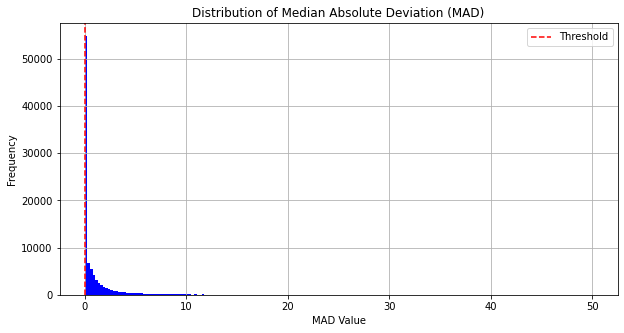

removing 46661 genes under the MAD threshold from the dataset
number of genes selected :  48648
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [2]:
# baseline

# a threshold had to be used to limit memory usage
dataset, index_names, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    log1p = True,
    min_max = True)                   

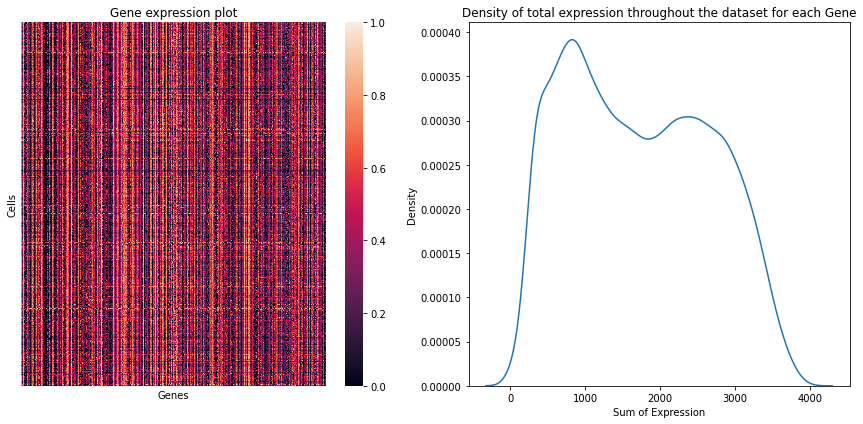

In [3]:
visualisation.dataset_plot(dataset)                                         



















































































































































































































































## Testing the first file, without and with treshold

In [3]:
suggested_genes_file = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
number of genes selected :  9061
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


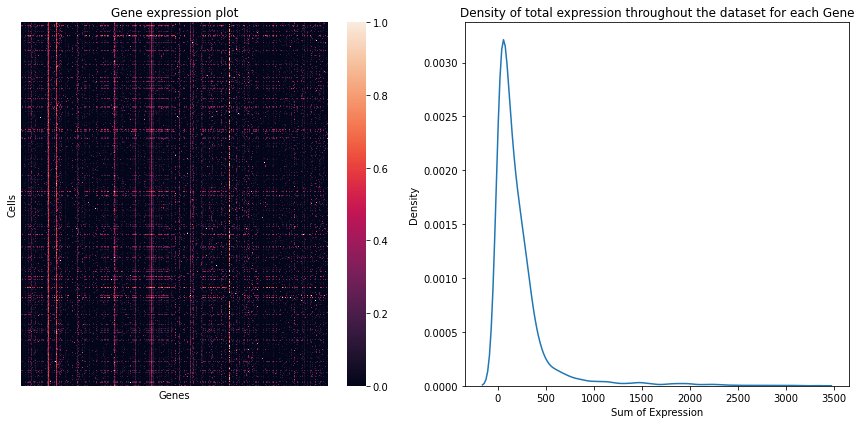

In [4]:
# first file, no threshold
dataset, index_names, n_genes, gene_names = data_handler.generate_dataset_transcripts(feature_selection_threshold = None, 
                                                            batch_size = 32, 
                                                            retain_phases = None,
                                                            normalization = False,
                                                            as_time_series = as_time_series,
                                                            MT_removal = False,
                                                            log1p = True,
                                                            min_max = True,
                                                            gene_selection_file = suggested_genes_file)                   

visualisation.dataset_plot(dataset)                                         


not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  0 ...
0.0
2225.368


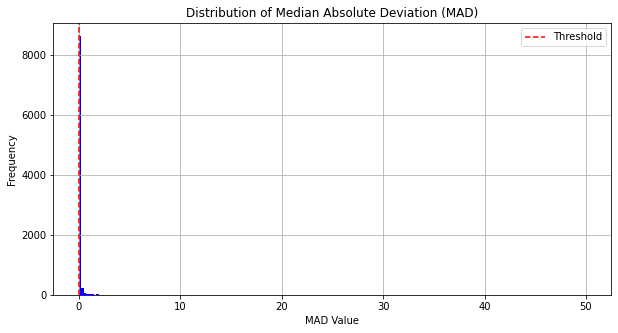

removing 6876 genes under the MAD threshold from the dataset
number of genes selected :  2185
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


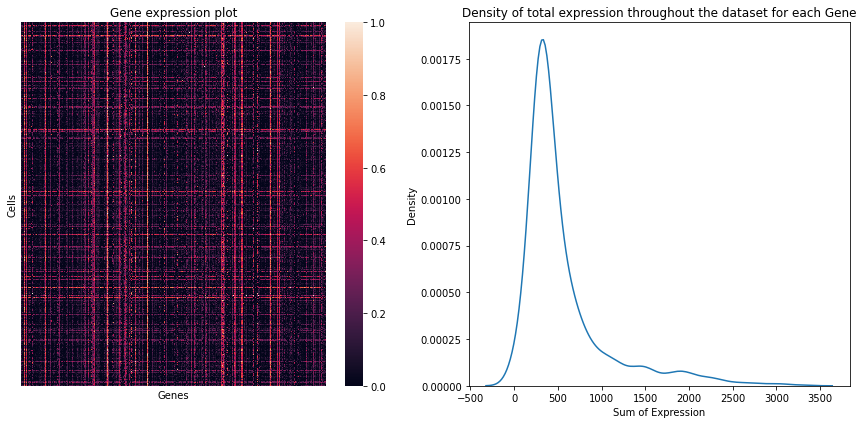

In [5]:
# first file, 0-threshold
dataset, index_names, n_genes, gene_names = data_handler.generate_dataset_transcripts(feature_selection_threshold = 0, 
                                                            batch_size = 32, 
                                                            retain_phases = None,
                                                            normalization = False,
                                                            as_time_series = as_time_series,
                                                            MT_removal = False,
                                                            log1p = True,
                                                            min_max = True,
                                                            gene_selection_file = suggested_genes_file)                   

visualisation.dataset_plot(dataset)                                         


## Testing the second file, without and with treshold

In [6]:
suggested_genes_file = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
number of genes selected :  4845
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


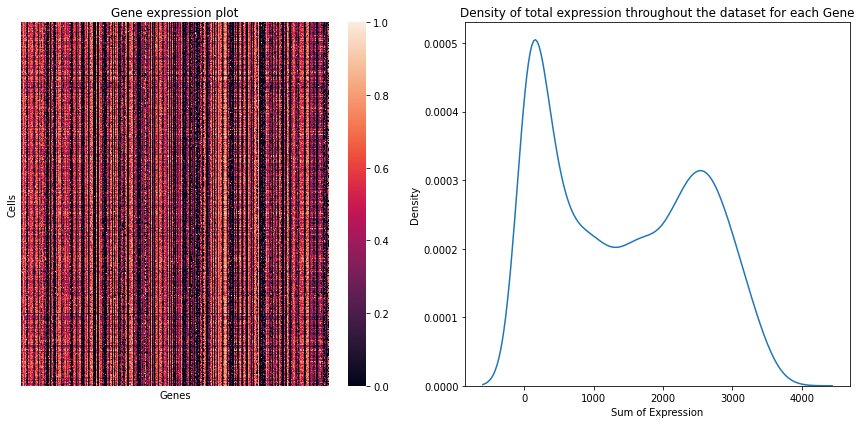

In [7]:
# second file, No threshold
dataset, index_names, n_genes, gene_names = data_handler.generate_dataset_transcripts(feature_selection_threshold = None, 
                                                            batch_size = 32, 
                                                            retain_phases = None,
                                                            normalization = False,
                                                            as_time_series = as_time_series,
                                                            MT_removal = False,
                                                            log1p = True,
                                                            min_max = True,
                                                            gene_selection_file = suggested_genes_file)                                                            
visualisation.dataset_plot(dataset)

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  0 ...
0.0
2225.368


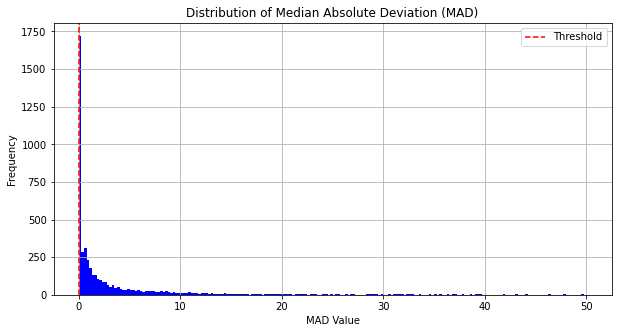

removing 1562 genes under the MAD threshold from the dataset
number of genes selected :  3283
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


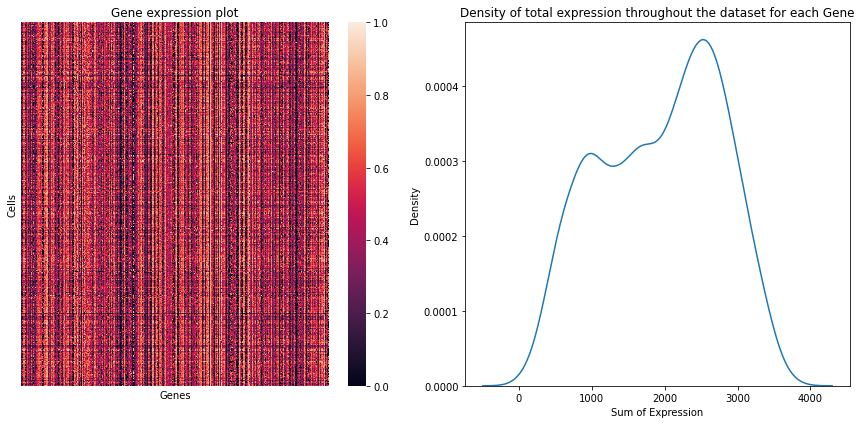

In [8]:
# second file, 0 threshold
dataset, index_names, n_genes, gene_names = data_handler.generate_dataset_transcripts(feature_selection_threshold = 0, 
                                                            batch_size = 32, 
                                                            retain_phases = None,
                                                            normalization = False,
                                                            as_time_series = as_time_series,
                                                            MT_removal = False,
                                                            log1p = True,
                                                            min_max = True,
                                                            gene_selection_file = suggested_genes_file)                                                            
visualisation.dataset_plot(dataset)


get the dataset as a numpy object for data manipulation

In [32]:
# get everything out of TensorFlow back to numpy/pandas
data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)
if(as_time_series):
    data = data.reshape(data.shape[0]*data.shape[1], -1)
    data = pd.DataFrame(data)
    data.columns = gene_names["name"]
    data.index = np.repeat(index_names, 5, axis=0)
else:
    data = pd.DataFrame(data)
    data.columns = gene_names["name"]
    data.index = index_names
